In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="HoleEffect")

/tmp/ipykernel_171329/3431087781.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


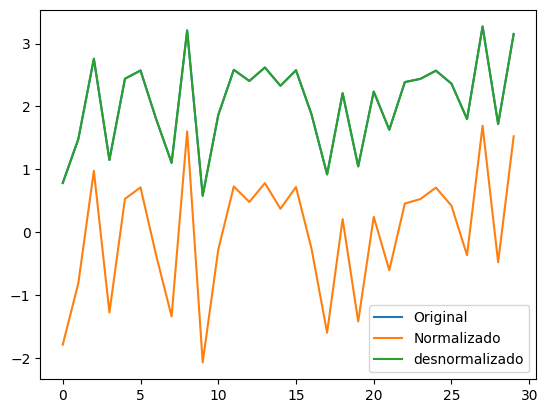

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 6.60 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-02 18:46:45.399956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 18:46:45.400001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 18:46:45.401255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 18:46:45.408165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-09-02 18:46:46.400317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_9,0.670260,0.375634,0.284299,0.566220,0.123456,0.370651,0.501363,0.059143,0.192454,0.351362,0.223736,0.354486,134.183748,312.036648
model_1_0_8,0.641838,0.343950,0.261678,0.561749,0.134097,0.389460,0.517210,0.059753,0.203955,0.366192,0.156828,0.369447,134.018390,311.871289
model_1_0_7,0.533576,0.284698,0.228561,0.324853,0.174630,0.424634,0.540409,0.092052,0.229156,0.417888,-0.098040,0.421602,133.490169,311.343068
model_1_0_6,0.523066,0.277872,0.225066,0.303192,0.178565,0.428686,0.542857,0.095005,0.231643,0.422570,-0.122782,0.426326,133.445604,311.298503
model_1_0_5,0.514796,0.272168,0.221460,0.285483,0.181662,0.432072,0.545383,0.097420,0.233546,0.426218,-0.142252,0.430006,133.411219,311.264118
model_1_0_4,0.455552,0.231733,0.186609,0.228400,0.203843,0.456076,0.569798,0.105203,0.247645,0.451489,-0.281721,0.455503,133.180814,311.033714
model_1_0_3,0.445021,0.224635,0.180590,0.212466,0.207786,0.460290,0.574014,0.107375,0.250087,0.455835,-0.306514,0.459887,133.142498,310.995397
model_1_0_2,0.367275,0.170429,0.124104,0.058905,0.236894,0.492469,0.613583,0.128313,0.265806,0.486717,-0.489540,0.491044,132.880287,310.733186
model_1_0_1,0.221937,0.109830,0.049137,0.191566,0.291308,0.528443,0.666099,0.110225,0.299263,0.539730,-0.831689,0.544528,132.466745,310.319645
model_1_0_0,0.111054,0.034191,0.029927,0.056844,0.332824,0.573346,0.679556,0.128594,0.325929,0.576909,-1.092728,0.582037,132.200286,310.053185


DataFrame salvo em ../results/metrics_1_0


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++

Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.878362,0.527682,0.403338,0.875539,0.045542,0.280388,0.417974,0.050053,0.115661,0.213405,0.713643,0.215302,136.178258,314.031157
model_1_1_8,0.877691,0.527040,0.401228,0.874472,0.045793,0.280770,0.419452,0.050482,0.115673,0.213993,0.712064,0.215895,136.167254,314.020153
model_1_1_7,0.863186,0.516937,0.386007,0.858823,0.051223,0.286767,0.430115,0.056775,0.121528,0.226326,0.677917,0.228338,135.943117,313.796016
model_1_1_6,0.846405,0.504028,0.367703,0.840688,0.057506,0.294430,0.442937,0.064068,0.128229,0.239805,0.638411,0.241937,135.711719,313.564618
model_1_1_5,0.831099,0.496416,0.365116,0.820154,0.063237,0.298949,0.444749,0.072326,0.132841,0.251469,0.602379,0.253705,135.521737,313.374636
model_1_1_4,0.812533,0.488904,0.359107,0.799172,0.070188,0.303408,0.448959,0.080764,0.138571,0.264930,0.558672,0.267285,135.313158,313.166057
model_1_1_2,0.780598,0.476236,0.350307,0.759906,0.082145,0.310929,0.455124,0.096555,0.148034,0.286609,0.483490,0.289157,134.998546,312.851445
model_1_1_3,0.786642,0.475494,0.346102,0.767951,0.079882,0.311369,0.458069,0.093320,0.146754,0.282634,0.497720,0.285146,135.054416,312.907315
model_1_1_1,0.748460,0.451290,0.345815,0.734587,0.094177,0.325738,0.458270,0.106737,0.161099,0.306883,0.407833,0.309611,134.725156,312.578056
model_1_1_0,0.678573,0.384762,0.295979,0.673821,0.120343,0.365232,0.493182,0.131174,0.189960,0.346905,0.243308,0.349988,134.234821,312.087720


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_8,0.959395,0.611634,0.541713,0.959755,0.015203,0.230551,0.321039,0.016860,0.065887,0.123299,0.904409,0.124395,138.372580,316.225479
model_1_2_9,0.959281,0.607769,0.540801,0.958294,0.015245,0.232845,0.321679,0.017472,0.066213,0.123471,0.904141,0.124569,138.366985,316.219884
model_1_2_7,0.954302,0.604503,0.531671,0.956285,0.017109,0.234784,0.328074,0.018314,0.070648,0.130803,0.892420,0.131966,138.136256,315.989155
model_1_2_6,0.948544,0.598779,0.517292,0.953328,0.019265,0.238182,0.338147,0.019553,0.075456,0.138799,0.878865,0.140033,137.898922,315.751821
model_1_2_5,0.942405,0.591923,0.503392,0.948413,0.021564,0.242252,0.347884,0.021612,0.079692,0.146846,0.864411,0.148152,137.673475,315.526375
model_1_2_4,0.935698,0.585004,0.492085,0.943788,0.024075,0.246360,0.355805,0.023550,0.084280,0.155160,0.848624,0.156539,137.453193,315.306093
model_1_2_3,0.926666,0.574506,0.475174,0.936211,0.027456,0.252592,0.367651,0.026724,0.090124,0.165699,0.827361,0.167172,137.190324,315.043223
model_1_2_2,0.917058,0.564766,0.459949,0.927961,0.031054,0.258374,0.378317,0.030180,0.095740,0.176221,0.804740,0.177787,136.944065,314.796964
model_1_2_1,0.905178,0.552409,0.440942,0.917847,0.035502,0.265709,0.391631,0.034418,0.102421,0.188419,0.776773,0.190094,136.676351,314.529250
model_1_2_0,0.892704,0.541914,0.423571,0.906194,0.040172,0.271940,0.403801,0.039299,0.108513,0.200429,0.747407,0.202211,136.429177,314.282077


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_3,0.974186,0.621744,0.571776,0.978669,0.009665,0.224549,0.299980,0.011275,0.053504,0.098309,0.939231,0.099183,139.278563,317.131462
model_1_3_2,0.970336,0.619121,0.565284,0.973457,0.011106,0.226106,0.304528,0.014030,0.057295,0.105387,0.930165,0.106324,139.000459,316.853358
model_1_3_4,0.974709,0.619083,0.572740,0.977854,0.009469,0.226129,0.299304,0.011706,0.052875,0.097310,0.940460,0.098175,139.319426,317.172325
model_1_3_8,0.977015,0.618823,0.572547,0.973068,0.008606,0.226283,0.299439,0.014236,0.047809,0.092767,0.945889,0.093592,139.510655,317.363555
model_1_3_6,0.974751,0.617966,0.570825,0.974052,0.009453,0.226792,0.300646,0.013716,0.050339,0.097228,0.940559,0.098093,139.322770,317.175669
model_1_3_5,0.973753,0.617528,0.569821,0.973822,0.009827,0.227052,0.301349,0.013837,0.052226,0.099131,0.938211,0.100012,139.245272,317.098171
model_1_3_9,0.977478,0.617262,0.575879,0.973956,0.008432,0.227210,0.297106,0.013767,0.047910,0.091827,0.946980,0.092644,139.551379,317.404278
model_1_3_7,0.975126,0.616635,0.569136,0.972826,0.009313,0.227582,0.301830,0.014364,0.050122,0.096503,0.941443,0.097361,139.352717,317.205616
model_1_3_1,0.966331,0.612181,0.553782,0.969178,0.012606,0.230226,0.312585,0.016292,0.061772,0.112275,0.920738,0.113273,138.747220,316.600119
model_1_3_0,0.960325,0.606382,0.542153,0.962501,0.014854,0.233668,0.320731,0.019822,0.066733,0.121879,0.906598,0.122962,138.418907,316.271806


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  35
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  47
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.993516,0.648790,0.603001,0.985764,0.002428,0.208493,0.278106,0.005562,0.021290,0.049272,0.984735,0.049710,142.041608,319.894507
model_1_4_8,0.993513,0.648616,0.603017,0.985879,0.002429,0.208597,0.278095,0.005518,0.021333,0.049282,0.984729,0.049720,142.040792,319.893691
model_1_4_7,0.993493,0.648406,0.602544,0.985983,0.002436,0.208721,0.278426,0.005477,0.021418,0.049358,0.984681,0.049797,142.034591,319.887491
model_1_4_6,0.993271,0.646727,0.599614,0.986667,0.002519,0.209718,0.280479,0.005210,0.022092,0.050194,0.984158,0.050640,141.967439,319.820338
model_1_4_4,0.991023,0.638034,0.591689,0.991071,0.003361,0.214879,0.286031,0.003489,0.028199,0.057973,0.978868,0.058488,141.391127,319.244027
model_1_4_5,0.991059,0.637679,0.591055,0.991027,0.003347,0.215089,0.286475,0.003506,0.028163,0.057856,0.978953,0.058371,141.399170,319.252069
model_1_4_3,0.987655,0.632532,0.584782,0.991033,0.004622,0.218145,0.290869,0.003504,0.033387,0.067985,0.970938,0.068589,140.753885,318.606784
model_1_4_2,0.984600,0.630511,0.576412,0.989439,0.005766,0.219345,0.296732,0.004127,0.036875,0.075934,0.963745,0.076609,140.311577,318.164476
model_1_4_0,0.979301,0.628785,0.579111,0.986082,0.007750,0.220369,0.294842,0.005438,0.043453,0.088033,0.951271,0.088816,139.720175,317.573074
model_1_4_1,0.980015,0.627975,0.577453,0.986751,0.007482,0.220850,0.296003,0.005177,0.042806,0.086501,0.952952,0.087270,139.790397,317.643296


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  36
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_3,0.993169,0.659233,0.624411,0.978249,0.002558,0.202294,0.263108,0.006939,0.021152,0.050573,0.983918,0.051022,141.937366,319.790265
model_1_5_2,0.993217,0.659226,0.624692,0.978624,0.002540,0.202298,0.262911,0.006819,0.021160,0.050394,0.984031,0.050842,141.951497,319.804396
model_1_5_9,0.992044,0.658361,0.627913,0.969484,0.002979,0.202812,0.260655,0.009735,0.021541,0.054579,0.981269,0.055064,141.632401,319.485301
model_1_5_8,0.992185,0.658294,0.627152,0.971043,0.002926,0.202851,0.261187,0.009238,0.021700,0.054092,0.981602,0.054572,141.668300,319.521200
model_1_5_4,0.992973,0.657458,0.623068,0.976901,0.002631,0.203347,0.264049,0.007369,0.021151,0.051292,0.983458,0.051748,141.880885,319.733785
model_1_5_7,0.992643,0.657310,0.622453,0.974161,0.002754,0.203436,0.264479,0.008243,0.021154,0.052482,0.982681,0.052949,141.789112,319.642011
model_1_5_6,0.992710,0.657235,0.622600,0.974768,0.002729,0.203480,0.264376,0.008049,0.021151,0.052243,0.982838,0.052708,141.807389,319.660288
model_1_5_5,0.992911,0.656952,0.623012,0.976346,0.002654,0.203648,0.264088,0.007546,0.021116,0.051518,0.983311,0.051976,141.863286,319.716185
model_1_5_0,0.993654,0.652932,0.616910,0.984236,0.002376,0.206035,0.268363,0.005029,0.021179,0.048744,0.985060,0.049178,142.084674,319.937573
model_1_5_1,0.993310,0.652388,0.618382,0.981700,0.002505,0.206358,0.267331,0.005838,0.021715,0.050048,0.984250,0.050493,141.979100,319.831999


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.992316,0.659049,0.628673,0.996390,0.002877,0.202403,0.260122,0.001208,0.020905,0.053637,0.981910,0.054114,141.702030,319.554929
model_1_6_1,0.992445,0.657332,0.626069,0.996277,0.002829,0.203422,0.261946,0.001246,0.020991,0.053185,0.982214,0.053658,141.735887,319.588786
model_1_6_2,0.992514,0.657308,0.625636,0.996171,0.002803,0.203437,0.262249,0.001281,0.020958,0.052942,0.982376,0.053413,141.754214,319.607114
model_1_6_3,0.992550,0.657068,0.624879,0.996038,0.002789,0.203579,0.262780,0.001325,0.020976,0.052812,0.982462,0.053282,141.764044,319.616944
model_1_6_4,0.992786,0.655291,0.620425,0.995213,0.002701,0.204634,0.265900,0.001601,0.021230,0.051970,0.983017,0.052432,141.828362,319.681261
model_1_6_7,0.992960,0.654500,0.616299,0.993840,0.002636,0.205104,0.268791,0.002061,0.021705,0.051341,0.983426,0.051798,141.877051,319.729950
model_1_6_8,0.992941,0.654346,0.615945,0.993583,0.002643,0.205195,0.269039,0.002147,0.021834,0.051410,0.983381,0.051867,141.871694,319.724593
model_1_6_9,0.992931,0.654239,0.615234,0.993061,0.002647,0.205259,0.269537,0.002321,0.022013,0.051446,0.983358,0.051903,141.868908,319.721807
model_1_6_6,0.992967,0.654169,0.616663,0.994157,0.002633,0.205300,0.268536,0.001955,0.021646,0.051315,0.983443,0.051772,141.879059,319.731958
model_1_6_5,0.992942,0.654142,0.617169,0.994336,0.002642,0.205316,0.268181,0.001895,0.021601,0.051405,0.983385,0.051862,141.872076,319.724976


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  26
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.993601,0.660921,0.607383,0.985419,0.002396,0.201292,0.275037,0.004999,0.022080,0.048945,0.984937,0.049380,142.068218,319.921117
model_1_7_1,0.993613,0.660684,0.614037,0.988488,0.002391,0.201433,0.270375,0.003947,0.021309,0.048900,0.984964,0.049335,142.071902,319.924801
model_1_7_8,0.993539,0.660497,0.606413,0.985309,0.002419,0.201544,0.275716,0.005037,0.022192,0.049182,0.984791,0.049619,142.048911,319.901810
model_1_7_2,0.993659,0.659528,0.611920,0.988060,0.002374,0.202119,0.271858,0.004094,0.021726,0.048724,0.985073,0.049157,142.086369,319.939268
model_1_7_0,0.993564,0.659422,0.613890,0.989261,0.002410,0.202182,0.270478,0.003682,0.021482,0.049088,0.984849,0.049524,142.056601,319.909500
model_1_7_6,0.993683,0.659419,0.610523,0.987333,0.002365,0.202184,0.272837,0.004343,0.021711,0.048632,0.985129,0.049065,142.093861,319.946760
model_1_7_7,0.993650,0.659386,0.609867,0.987104,0.002377,0.202203,0.273296,0.004422,0.021782,0.048758,0.985052,0.049191,142.083548,319.936447
model_1_7_3,0.993647,0.659370,0.611011,0.987776,0.002379,0.202213,0.272495,0.004191,0.021785,0.048771,0.985044,0.049205,142.082457,319.935357
model_1_7_5,0.993664,0.659342,0.610655,0.987451,0.002372,0.202229,0.272744,0.004303,0.021757,0.048705,0.985084,0.049138,142.087854,319.940754
model_1_7_4,0.993651,0.659289,0.610640,0.987663,0.002377,0.202261,0.272755,0.004230,0.021798,0.048755,0.985054,0.049188,142.083793,319.936692


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.993643,0.660463,0.608626,0.994153,0.002380,0.201564,0.274166,0.002163,0.022067,0.048785,0.985035,0.049218,142.081348,319.934247
model_1_8_1,0.994170,0.660048,0.609288,0.994420,0.002183,0.201810,0.273702,0.002065,0.021330,0.046720,0.986276,0.047135,142.254370,320.107269
model_1_8_5,0.994900,0.659684,0.604149,0.993931,0.001909,0.202026,0.277302,0.002245,0.021169,0.043697,0.987994,0.044086,142.521873,320.374772
model_1_8_6,0.994917,0.659365,0.604403,0.993904,0.001903,0.202216,0.277124,0.002256,0.021172,0.043626,0.988033,0.044014,142.528383,320.381282
model_1_8_7,0.995156,0.659214,0.603407,0.993653,0.001814,0.202306,0.277821,0.002349,0.020946,0.042587,0.988596,0.042966,142.624789,320.477689
model_1_8_9,0.995381,0.659018,0.600472,0.992806,0.001729,0.202422,0.279878,0.002662,0.020838,0.041584,0.989127,0.041954,142.720129,320.573028
model_1_8_2,0.994196,0.657738,0.605131,0.994144,0.002173,0.203181,0.276614,0.002167,0.021948,0.046616,0.986336,0.047030,142.263276,320.116175
model_1_8_4,0.994535,0.657733,0.603989,0.993932,0.002046,0.203184,0.277414,0.002245,0.021666,0.045233,0.987135,0.045635,142.383755,320.236654
model_1_8_3,0.994197,0.657676,0.604726,0.994087,0.002173,0.203218,0.276897,0.002188,0.022023,0.046611,0.986339,0.047026,142.263642,320.116541
model_1_8_8,0.995125,0.657266,0.601271,0.993404,0.001825,0.203462,0.279318,0.002440,0.021294,0.042724,0.988522,0.043104,142.611943,320.464842


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.995388,0.657412,0.598095,0.996387,0.001727,0.203375,0.281543,0.001346,0.020905,0.041553,0.989143,0.041922,142.723186,320.576085
model_1_9_9,0.994886,0.654326,0.616947,0.986636,0.001915,0.205207,0.268337,0.004978,0.020542,0.043755,0.987962,0.044144,142.516560,320.369459
model_1_9_2,0.994988,0.653768,0.595554,0.994032,0.001876,0.205538,0.283323,0.002223,0.021684,0.043317,0.988202,0.043702,142.556842,320.409741
model_1_9_1,0.995046,0.653557,0.595462,0.994418,0.001855,0.205664,0.283387,0.002079,0.021452,0.043065,0.988339,0.043448,142.580156,320.433056
model_1_9_8,0.994735,0.652669,0.610032,0.986521,0.001971,0.206191,0.273181,0.005021,0.021245,0.044400,0.987605,0.044794,142.458085,320.310984
model_1_9_3,0.994383,0.650013,0.593152,0.989828,0.002103,0.207767,0.285005,0.003789,0.022794,0.045857,0.986777,0.046265,142.328889,320.181788
model_1_9_4,0.993869,0.647404,0.593790,0.985928,0.002296,0.209316,0.284559,0.005242,0.023268,0.047912,0.985566,0.048338,142.153585,320.006484
model_1_9_5,0.993673,0.645727,0.594165,0.984586,0.002369,0.210312,0.284296,0.005742,0.023455,0.048672,0.985105,0.049104,142.090638,319.943537
model_1_9_7,0.993748,0.645521,0.596211,0.984041,0.002341,0.210434,0.282862,0.005945,0.023203,0.048382,0.985281,0.048812,142.114513,319.967412
model_1_9_6,0.993689,0.645349,0.595841,0.984003,0.002363,0.210536,0.283122,0.005959,0.023314,0.048611,0.985142,0.049043,142.095661,319.948560


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_3,0.995291,0.657811,0.620211,0.995550,0.001763,0.203138,0.266050,0.001789,0.019357,0.041988,0.988915,0.042362,142.681460,320.534359
model_1_10_2,0.995255,0.657719,0.619859,0.995621,0.001777,0.203192,0.266297,0.001761,0.019462,0.042151,0.988828,0.042526,142.666001,320.518900
model_1_10_1,0.995225,0.657718,0.619583,0.995728,0.001788,0.203193,0.266490,0.001717,0.019550,0.042281,0.988760,0.042656,142.653708,320.506607
model_1_10_0,0.995181,0.657456,0.620042,0.995742,0.001804,0.203349,0.266168,0.001712,0.019623,0.042475,0.988656,0.042853,142.635346,320.488245
model_1_10_4,0.995167,0.657336,0.618346,0.994139,0.001809,0.203420,0.267356,0.002356,0.019679,0.042538,0.988623,0.042916,142.629472,320.482372
model_1_10_5,0.995176,0.656724,0.617756,0.993982,0.001806,0.203783,0.267770,0.002419,0.019701,0.042500,0.988643,0.042878,142.632995,320.485895
model_1_10_6,0.995161,0.656117,0.616777,0.993155,0.001812,0.204144,0.268456,0.002752,0.019711,0.042567,0.988607,0.042945,142.626738,320.479638
model_1_10_7,0.994989,0.654654,0.615905,0.991696,0.001876,0.205012,0.269067,0.003338,0.019938,0.043315,0.988203,0.043700,142.557062,320.409961
model_1_10_8,0.995043,0.654284,0.615759,0.990799,0.001856,0.205232,0.269169,0.003699,0.019895,0.043079,0.988331,0.043462,142.578837,320.431737
model_1_10_9,0.994199,0.644554,0.597354,0.985724,0.002172,0.211008,0.282062,0.005739,0.020336,0.046603,0.986344,0.047017,142.264381,320.117280


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_2,0.994510,0.645849,0.590506,0.993742,0.002055,0.210239,0.286859,0.002528,0.020441,0.045337,0.987076,0.045740,142.374568,320.227467
model_1_11_3,0.994536,0.645765,0.591084,0.993700,0.002046,0.210289,0.286454,0.002545,0.020354,0.045232,0.987136,0.045634,142.383842,320.236741
model_1_11_1,0.994316,0.644672,0.597273,0.995238,0.002128,0.210938,0.282119,0.001924,0.020315,0.046132,0.986619,0.046542,142.304989,320.157889
model_1_11_0,0.994256,0.644435,0.596783,0.995231,0.002150,0.211079,0.282462,0.001927,0.020377,0.046372,0.986479,0.046784,142.284215,320.137114
model_1_11_4,0.994727,0.643837,0.586567,0.993047,0.001974,0.211433,0.289618,0.002809,0.020179,0.044432,0.987587,0.044827,142.455214,320.308113
model_1_11_5,0.994740,0.643438,0.586278,0.992913,0.001969,0.211670,0.289821,0.002863,0.020141,0.044376,0.987618,0.044771,142.460218,320.313117
model_1_11_7,0.994780,0.643049,0.585304,0.992780,0.001954,0.211902,0.290503,0.002917,0.020073,0.044208,0.987712,0.044601,142.475434,320.328333
model_1_11_6,0.994760,0.643042,0.585306,0.992828,0.001962,0.211906,0.290501,0.002897,0.020123,0.044292,0.987664,0.044686,142.467768,320.320667
model_1_11_8,0.994797,0.643032,0.584803,0.992699,0.001948,0.211912,0.290854,0.002949,0.020015,0.044136,0.987751,0.044529,142.481878,320.334777
model_1_11_9,0.994822,0.642561,0.583676,0.992621,0.001939,0.212191,0.291643,0.002981,0.019992,0.044030,0.987810,0.044421,142.491573,320.344472


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_1,0.994881,0.643058,0.585229,0.991901,0.001917,0.211896,0.290556,0.002935,0.019872,0.043779,0.987949,0.044168,142.514445,320.367344
model_1_12_9,0.994986,0.642577,0.591022,0.987511,0.001877,0.212182,0.286497,0.004526,0.019078,0.043329,0.988195,0.043714,142.555726,320.408626
model_1_12_0,0.994854,0.642498,0.584134,0.991971,0.001927,0.212228,0.291323,0.002910,0.019958,0.043896,0.987885,0.044286,142.503772,320.356671
model_1_12_5,0.994901,0.640750,0.583882,0.990698,0.001909,0.213266,0.291499,0.003371,0.019828,0.043692,0.987997,0.044080,142.522365,320.375264
model_1_12_2,0.994835,0.640616,0.582756,0.990893,0.001934,0.213346,0.292288,0.003301,0.019932,0.043974,0.987841,0.044365,142.496601,320.349501
model_1_12_4,0.994863,0.640311,0.582854,0.990711,0.001923,0.213527,0.292220,0.003366,0.019907,0.043854,0.987908,0.044244,142.507564,320.360463
model_1_12_3,0.994841,0.640203,0.582466,0.990791,0.001931,0.213591,0.292491,0.003337,0.019950,0.043948,0.987856,0.044338,142.499030,320.351929
model_1_12_6,0.994803,0.638403,0.580874,0.989621,0.001946,0.214660,0.293607,0.003761,0.020041,0.044109,0.987766,0.044501,142.484358,320.337257
model_1_12_7,0.994659,0.636724,0.580809,0.988672,0.002000,0.215656,0.293652,0.004105,0.020398,0.044717,0.987427,0.045115,142.429566,320.282465
model_1_12_8,0.994522,0.636419,0.581219,0.987152,0.002051,0.215837,0.293365,0.004656,0.020187,0.045289,0.987103,0.045691,142.378774,320.231673


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  32
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  23
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++

Stopped at epoch:  25
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  44
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_8,0.994033,0.653868,0.623764,0.982479,0.002234,0.205479,0.263561,0.008127,0.018176,0.047264,0.985954,0.047684,142.208007,320.060906
model_1_13_9,0.993976,0.653522,0.624022,0.982204,0.002255,0.205684,0.263381,0.008255,0.018196,0.047489,0.985819,0.047912,142.188993,320.041892
model_1_13_6,0.994103,0.652915,0.621398,0.983037,0.002208,0.206045,0.265219,0.007869,0.018423,0.046988,0.986118,0.047405,142.231485,320.084384
model_1_13_7,0.994110,0.652858,0.621248,0.983042,0.002205,0.206078,0.265324,0.007866,0.018403,0.046959,0.986135,0.047376,142.233927,320.086826
model_1_13_5,0.994311,0.651806,0.616804,0.984467,0.002130,0.206703,0.268437,0.007205,0.018668,0.046152,0.986607,0.046562,142.303249,320.156149
model_1_13_4,0.994724,0.650495,0.606787,0.987630,0.001975,0.207481,0.275454,0.005738,0.018844,0.044444,0.987580,0.044839,142.454116,320.307015
model_1_13_3,0.994743,0.650179,0.606108,0.987744,0.001968,0.207669,0.275930,0.005685,0.018877,0.044364,0.987625,0.044758,142.461340,320.314239
model_1_13_2,0.994890,0.646699,0.599279,0.989696,0.001913,0.209735,0.280713,0.004780,0.019309,0.043742,0.987969,0.044131,142.517794,320.370693
model_1_13_1,0.994915,0.645396,0.594298,0.991293,0.001904,0.210509,0.284203,0.004039,0.019556,0.043635,0.988028,0.044023,142.527580,320.380479
model_1_13_0,0.994950,0.645345,0.593967,0.991517,0.001891,0.210539,0.284434,0.003935,0.019480,0.043482,0.988112,0.043869,142.541620,320.394519


DataFrame salvo em ../results/metrics_1_13


+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_8,0.995573,0.656464,0.621424,0.992694,0.001657,0.203938,0.265201,0.002557,0.017330,0.040711,0.989579,0.041073,142.805016,320.657916
model_1_14_7,0.995539,0.655944,0.621534,0.992793,0.001670,0.204246,0.265123,0.002522,0.017341,0.040867,0.989499,0.041230,142.789732,320.642631
model_1_14_9,0.995608,0.654784,0.619948,0.992737,0.001645,0.204935,0.266235,0.002542,0.017428,0.040553,0.989659,0.040914,142.820574,320.673473
model_1_14_3,0.994826,0.654204,0.620615,0.993352,0.001937,0.205280,0.265767,0.002327,0.017832,0.044012,0.987820,0.044403,142.493204,320.346103
model_1_14_4,0.994958,0.653603,0.619835,0.993171,0.001888,0.205636,0.266314,0.002390,0.018035,0.043448,0.988130,0.043835,142.544729,320.397628
model_1_14_0,0.994026,0.653534,0.624079,0.993869,0.002237,0.205677,0.263340,0.002146,0.018210,0.047293,0.985936,0.047714,142.205532,320.058431
model_1_14_6,0.995015,0.653526,0.619784,0.993149,0.001866,0.205682,0.266349,0.002398,0.018015,0.043201,0.988265,0.043585,142.567604,320.420503
model_1_14_5,0.994964,0.653394,0.619682,0.993122,0.001885,0.205760,0.266421,0.002407,0.018089,0.043421,0.988145,0.043807,142.547276,320.400175
model_1_14_2,0.994603,0.652846,0.623337,0.993316,0.002021,0.206085,0.263860,0.002339,0.018227,0.044951,0.987295,0.045351,142.408708,320.261607
model_1_14_1,0.994312,0.652396,0.623160,0.993404,0.002129,0.206352,0.263984,0.002309,0.018444,0.046146,0.986610,0.046557,142.303749,320.156649


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_9,0.993827,0.673319,0.686041,0.977371,0.002311,0.193932,0.219935,0.006280,0.019245,0.048076,0.985467,0.048503,142.139908,319.992807
model_1_15_8,0.994416,0.672587,0.683660,0.981922,0.002091,0.194366,0.221603,0.005017,0.018986,0.045724,0.986854,0.046130,142.340552,320.193451
model_1_15_7,0.994853,0.671360,0.679867,0.985575,0.001927,0.195095,0.224260,0.004003,0.018808,0.043898,0.987883,0.044288,142.503557,320.356456
model_1_15_6,0.995205,0.669784,0.674728,0.988682,0.001795,0.196031,0.227860,0.003141,0.018602,0.042369,0.988712,0.042746,142.645335,320.498234
model_1_15_5,0.995270,0.669525,0.673435,0.989356,0.001771,0.196184,0.228766,0.002954,0.018569,0.042081,0.988866,0.042455,142.672638,320.525537
model_1_15_4,0.995326,0.668830,0.671497,0.990000,0.001750,0.196597,0.230123,0.002775,0.018541,0.041831,0.988997,0.042203,142.696461,320.549360
model_1_15_3,0.995607,0.666603,0.663361,0.992650,0.001645,0.197919,0.235823,0.002040,0.018169,0.040554,0.989659,0.040915,142.820470,320.673369
model_1_15_2,0.995737,0.665165,0.656808,0.994160,0.001596,0.198772,0.240413,0.001621,0.017781,0.039951,0.989964,0.040306,142.880454,320.733353
model_1_15_1,0.995768,0.660797,0.641110,0.995876,0.001584,0.201365,0.251410,0.001144,0.017505,0.039805,0.990037,0.040159,142.895017,320.747916
model_1_15_0,0.995653,0.656468,0.624048,0.996474,0.001628,0.203935,0.263362,0.000978,0.017328,0.040344,0.989766,0.040703,142.841225,320.694124


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.994297,0.669586,0.686128,0.991174,0.002135,0.196148,0.219874,0.003323,0.019744,0.046207,0.986575,0.046618,142.298480,320.151379
model_1_16_2,0.994728,0.669481,0.684751,0.989270,0.001974,0.196210,0.220839,0.004040,0.018967,0.044428,0.987589,0.044823,142.455534,320.308434
model_1_16_1,0.994601,0.669097,0.684986,0.989376,0.002022,0.196438,0.220674,0.004001,0.019232,0.044962,0.987289,0.045362,142.407765,320.260664
model_1_16_3,0.994713,0.668726,0.684074,0.988625,0.001979,0.196659,0.221313,0.004284,0.019116,0.044491,0.987554,0.044886,142.449888,320.302788
model_1_16_4,0.994370,0.664081,0.677171,0.985802,0.002108,0.199416,0.226148,0.005346,0.020070,0.045914,0.986745,0.046322,142.323976,320.176876
model_1_16_5,0.994403,0.662349,0.676569,0.984914,0.002096,0.200444,0.226570,0.005681,0.020080,0.045778,0.986823,0.046185,142.335764,320.188663
model_1_16_7,0.994554,0.661248,0.675081,0.984124,0.002039,0.201098,0.227613,0.005978,0.019777,0.045156,0.987179,0.045557,142.390551,320.243450
model_1_16_6,0.994401,0.661201,0.675458,0.984355,0.002096,0.201125,0.227348,0.005891,0.020155,0.045784,0.986819,0.046191,142.335252,320.188151
model_1_16_9,0.994712,0.660979,0.674431,0.983262,0.001980,0.201257,0.228068,0.006303,0.019189,0.044497,0.987550,0.044892,142.449340,320.302239
model_1_16_8,0.994615,0.660709,0.674341,0.983703,0.002016,0.201418,0.228131,0.006137,0.019621,0.044902,0.987323,0.045301,142.413108,320.266007


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++

Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_9,0.992743,0.668356,0.664592,0.965495,0.002717,0.196878,0.234960,0.008190,0.020642,0.052125,0.982916,0.052588,141.816447,319.669346
model_1_17_8,0.993152,0.666850,0.664614,0.970024,0.002564,0.197772,0.234945,0.007115,0.020535,0.050636,0.983878,0.051086,141.932389,319.785288
model_1_17_7,0.993650,0.666449,0.664977,0.974661,0.002378,0.198010,0.234691,0.006014,0.020180,0.048760,0.985051,0.049193,142.083405,319.936305
model_1_17_6,0.993960,0.665460,0.666073,0.978830,0.002262,0.198597,0.233923,0.005025,0.020228,0.047555,0.985780,0.047978,142.183447,320.036346
model_1_17_5,0.994194,0.664514,0.666861,0.982226,0.002174,0.199159,0.233370,0.004219,0.020199,0.046625,0.986331,0.047040,142.262450,320.115349
model_1_17_4,0.994251,0.664506,0.666730,0.982768,0.002153,0.199164,0.233463,0.004090,0.020151,0.046396,0.986465,0.046809,142.282142,320.135041
model_1_17_1,0.994921,0.661851,0.672357,0.993760,0.001902,0.200740,0.229521,0.001481,0.019346,0.043607,0.988043,0.043994,142.530173,320.383073
model_1_17_0,0.994817,0.661455,0.674299,0.996205,0.001941,0.200975,0.228160,0.000901,0.019100,0.044051,0.987798,0.044443,142.489585,320.342484
model_1_17_2,0.994534,0.661054,0.666728,0.988326,0.002046,0.201213,0.233464,0.002771,0.020110,0.045238,0.987132,0.045640,142.383271,320.236170
model_1_17_3,0.994477,0.661013,0.666297,0.987758,0.002068,0.201237,0.233766,0.002906,0.020205,0.045472,0.986999,0.045876,142.362649,320.215548


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_4,0.994366,0.670570,0.666326,0.995199,0.002109,0.195564,0.233745,0.002410,0.019313,0.045928,0.986737,0.046336,142.322732,320.175631
model_1_18_3,0.994010,0.669596,0.665171,0.995377,0.002242,0.196142,0.234554,0.002320,0.019674,0.047355,0.985900,0.047776,142.200333,320.053232
model_1_18_2,0.993949,0.669470,0.665055,0.995399,0.002265,0.196217,0.234636,0.002309,0.019735,0.047597,0.985755,0.048020,142.179934,320.032833
model_1_18_6,0.994595,0.668751,0.666098,0.994734,0.002024,0.196644,0.233906,0.002643,0.019640,0.044985,0.987276,0.045385,142.405692,320.258591
model_1_18_7,0.994575,0.668735,0.666551,0.994628,0.002031,0.196653,0.233588,0.002696,0.019702,0.045068,0.987229,0.045469,142.398309,320.251209
model_1_18_9,0.994908,0.668653,0.666099,0.994213,0.001907,0.196702,0.233905,0.002905,0.019567,0.043664,0.988012,0.044053,142.524884,320.377784
model_1_18_0,0.992831,0.668634,0.664916,0.995732,0.002684,0.196713,0.234733,0.002142,0.020540,0.051810,0.983122,0.052270,141.840708,319.693607
model_1_18_8,0.994772,0.668463,0.665160,0.994471,0.001957,0.196814,0.234562,0.002775,0.019607,0.044243,0.987692,0.044636,142.472263,320.325162
model_1_18_1,0.993323,0.668407,0.664254,0.995649,0.002500,0.196848,0.235197,0.002184,0.020185,0.049998,0.984282,0.050443,141.983062,319.835962
model_1_18_5,0.994317,0.668023,0.665365,0.994865,0.002128,0.197076,0.234418,0.002578,0.019948,0.046129,0.986621,0.046539,142.305295,320.158194


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_3,0.995475,0.669313,0.666720,0.992897,0.001694,0.196310,0.233470,0.001590,0.018844,0.041161,0.989347,0.041527,142.761090,320.613989
model_1_19_4,0.995496,0.669216,0.666557,0.992881,0.001686,0.196368,0.233583,0.001594,0.018811,0.041064,0.989397,0.041429,142.770521,320.623420
model_1_19_0,0.995204,0.669110,0.665719,0.993738,0.001796,0.196431,0.234171,0.001402,0.019220,0.042374,0.988710,0.042750,142.644905,320.497804
model_1_19_1,0.995210,0.668925,0.665064,0.993692,0.001793,0.196540,0.234630,0.001412,0.019214,0.042346,0.988725,0.042723,142.647492,320.500392
model_1_19_2,0.995215,0.668858,0.665070,0.993434,0.001791,0.196580,0.234625,0.001470,0.019250,0.042325,0.988736,0.042701,142.649503,320.502402
model_1_19_5,0.995466,0.668294,0.664023,0.991876,0.001697,0.196915,0.235359,0.001819,0.018996,0.041199,0.989327,0.041565,142.757348,320.610247
model_1_19_6,0.995463,0.667955,0.663720,0.991546,0.001698,0.197116,0.235571,0.001893,0.019034,0.041213,0.989320,0.041579,142.756041,320.608940
model_1_19_7,0.995584,0.667765,0.662114,0.991187,0.001654,0.197229,0.236696,0.001973,0.018959,0.040663,0.989603,0.041025,142.809710,320.662609
model_1_19_9,0.995760,0.667465,0.658446,0.990257,0.001587,0.197407,0.239265,0.002181,0.018834,0.039842,0.990019,0.040196,142.891306,320.744205
model_1_19_8,0.995588,0.667073,0.659071,0.990560,0.001652,0.197640,0.238828,0.002113,0.019099,0.040643,0.989613,0.041005,142.811666,320.664565


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.994211,0.675671,0.673566,0.981218,0.002167,0.192536,0.228674,0.007431,0.019362,0.046556,0.986372,0.046970,142.268409,320.121308
model_1_20_7,0.994480,0.674920,0.672329,0.983710,0.002067,0.192982,0.229541,0.006446,0.019702,0.045460,0.987006,0.045864,142.363733,320.216632
model_1_20_8,0.994282,0.674822,0.672958,0.982570,0.002141,0.193039,0.229100,0.006897,0.019839,0.046267,0.986540,0.046679,142.293280,320.146179
model_1_20_6,0.994924,0.673812,0.670108,0.986486,0.001901,0.193640,0.231097,0.005347,0.019684,0.043595,0.988050,0.043982,142.531262,320.384161
model_1_20_5,0.995161,0.673208,0.668879,0.988030,0.001812,0.193998,0.231957,0.004736,0.019576,0.042565,0.988608,0.042943,142.626906,320.479805
model_1_20_4,0.995325,0.672542,0.667349,0.989399,0.001750,0.194393,0.233029,0.004195,0.019531,0.041836,0.988995,0.042208,142.696007,320.548906
model_1_20_3,0.995772,0.672376,0.664661,0.992922,0.001583,0.194492,0.234912,0.002801,0.019213,0.039786,0.990047,0.040140,142.896955,320.749854
model_1_20_2,0.995925,0.671927,0.662359,0.994901,0.001526,0.194758,0.236525,0.002018,0.018984,0.039059,0.990407,0.039407,142.970687,320.823586
model_1_20_1,0.995973,0.671902,0.660337,0.995871,0.001508,0.194773,0.237941,0.001634,0.018726,0.038828,0.990521,0.039173,142.994481,320.847381
model_1_20_0,0.995873,0.667589,0.658182,0.996190,0.001545,0.197334,0.239451,0.001507,0.018648,0.039307,0.990285,0.039657,142.945366,320.798265


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++

Stopped at epoch:  26
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  24
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  28
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.994104,0.675626,0.673808,0.998220,0.002207,0.192562,0.228504,0.000737,0.019369,0.046984,0.986120,0.047401,142.231810,320.084710
model_1_21_1,0.995110,0.673661,0.667204,0.997092,0.001831,0.193729,0.233130,0.001204,0.018750,0.042789,0.988488,0.043169,142.605908,320.458807
model_1_21_2,0.995279,0.672237,0.664822,0.996568,0.001767,0.194575,0.234799,0.001421,0.018872,0.042041,0.988887,0.042415,142.676457,320.529356
model_1_21_3,0.995275,0.671657,0.664228,0.996420,0.001769,0.194919,0.235216,0.001482,0.018996,0.042062,0.988876,0.042435,142.674482,320.527381
model_1_21_4,0.995498,0.671234,0.661584,0.995854,0.001686,0.195170,0.237068,0.001716,0.018793,0.041057,0.989401,0.041422,142.771176,320.624075
model_1_21_5,0.995523,0.671219,0.661285,0.995768,0.001676,0.195179,0.237277,0.001752,0.018767,0.040940,0.989461,0.041304,142.782630,320.635529
model_1_21_6,0.995761,0.669225,0.656511,0.994112,0.001587,0.196363,0.240621,0.002438,0.018405,0.039840,0.990020,0.040194,142.891578,320.744477
model_1_21_7,0.995777,0.668289,0.654615,0.993464,0.001581,0.196918,0.241949,0.002706,0.018361,0.039763,0.990058,0.040117,142.899225,320.752125
model_1_21_8,0.995800,0.665766,0.648859,0.990785,0.001572,0.198416,0.245981,0.003815,0.017717,0.039654,0.990113,0.040006,142.910264,320.763163
model_1_21_9,0.995782,0.664415,0.643765,0.989125,0.001579,0.199218,0.249550,0.004502,0.017171,0.039741,0.990070,0.040094,142.901525,320.754424


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.995821,0.663818,0.640903,0.994620,0.001565,0.199572,0.251555,0.002423,0.016987,0.039555,0.990162,0.039907,142.920255,320.773154
model_1_22_1,0.995984,0.662388,0.636407,0.993896,0.001504,0.200421,0.254704,0.002749,0.016997,0.038775,0.990546,0.039120,142.999887,320.852786
model_1_22_2,0.995997,0.661872,0.634515,0.993668,0.001499,0.200727,0.256030,0.002851,0.017015,0.038714,0.990576,0.039058,143.006214,320.859113
model_1_22_3,0.996015,0.661714,0.633529,0.993542,0.001492,0.200821,0.256720,0.002908,0.016973,0.038626,0.990619,0.038969,143.015342,320.868241
model_1_22_4,0.996049,0.660821,0.630501,0.993029,0.001479,0.201351,0.258842,0.003139,0.016955,0.038463,0.990698,0.038804,143.032283,320.885182
model_1_22_5,0.996028,0.660189,0.629316,0.992884,0.001487,0.201726,0.259672,0.003205,0.017057,0.038562,0.990650,0.038905,143.021940,320.874839
model_1_22_6,0.996026,0.660035,0.628781,0.992792,0.001488,0.201818,0.260046,0.003246,0.017062,0.038573,0.990644,0.038916,143.020782,320.873681
model_1_22_7,0.996019,0.656576,0.617456,0.990992,0.001491,0.203871,0.267980,0.004056,0.017061,0.038608,0.990627,0.038952,143.017132,320.870031
model_1_22_8,0.995972,0.655582,0.613394,0.990064,0.001508,0.204461,0.270825,0.004474,0.016958,0.038833,0.990518,0.039178,142.993913,320.846812
model_1_22_9,0.995863,0.654613,0.611066,0.989412,0.001549,0.205037,0.272456,0.004768,0.017106,0.039356,0.990261,0.039706,142.940377,320.793276


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_2,0.996019,0.654646,0.612908,0.994803,0.001490,0.205017,0.271166,0.001652,0.016961,0.038605,0.990629,0.038948,143.017538,320.870437
model_1_23_1,0.995992,0.654637,0.612711,0.994908,0.001500,0.205022,0.271304,0.001618,0.016991,0.038736,0.990566,0.039080,143.003987,320.856886
model_1_23_0,0.995966,0.654535,0.611727,0.994981,0.001510,0.205083,0.271993,0.001595,0.016988,0.038864,0.990503,0.039209,142.990786,320.843685
model_1_23_3,0.996300,0.654476,0.614005,0.993147,0.001385,0.205118,0.270397,0.002178,0.016655,0.037221,0.991289,0.037552,143.163520,321.016420
model_1_23_9,0.996472,0.653690,0.625584,0.989725,0.001321,0.205584,0.262286,0.003266,0.016150,0.036346,0.991693,0.036669,143.258655,321.111554
model_1_23_8,0.996461,0.653638,0.623867,0.990262,0.001325,0.205616,0.263489,0.003095,0.016263,0.036403,0.991667,0.036727,143.252389,321.105288
model_1_23_4,0.996291,0.653390,0.616686,0.992342,0.001389,0.205763,0.268519,0.002434,0.016859,0.037266,0.991268,0.037597,143.158725,321.011624
model_1_23_7,0.996424,0.653386,0.622023,0.990848,0.001339,0.205765,0.264781,0.002909,0.016456,0.036588,0.991582,0.036914,143.232090,321.084989
model_1_23_5,0.996381,0.653226,0.620166,0.991539,0.001355,0.205860,0.266082,0.002689,0.016646,0.036809,0.991481,0.037136,143.208088,321.060987
model_1_23_6,0.996396,0.653164,0.620384,0.991523,0.001350,0.205897,0.265929,0.002694,0.016609,0.036736,0.991515,0.037062,143.216030,321.068929


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_4,0.996463,0.654402,0.631004,0.992826,0.001324,0.205162,0.258489,0.004020,0.016063,0.036390,0.991673,0.036714,143.253828,321.106727
model_1_24_1,0.996516,0.654342,0.627835,0.994165,0.001304,0.205198,0.260710,0.003270,0.016042,0.036117,0.991798,0.036438,143.283965,321.136864
model_1_24_3,0.996485,0.654335,0.630603,0.993316,0.001316,0.205202,0.258770,0.003746,0.016086,0.036277,0.991725,0.036599,143.266329,321.119228
model_1_24_5,0.996371,0.654294,0.632363,0.992402,0.001359,0.205226,0.257537,0.004258,0.016191,0.036861,0.991456,0.037189,143.202378,321.055277
model_1_24_7,0.996221,0.654186,0.633941,0.991429,0.001415,0.205290,0.256432,0.004804,0.016387,0.037614,0.991104,0.037949,143.121485,320.974384
model_1_24_2,0.996499,0.654161,0.628649,0.993956,0.001311,0.205305,0.260139,0.003387,0.016101,0.036204,0.991758,0.036526,143.274325,321.127224
model_1_24_8,0.996195,0.654018,0.633826,0.991340,0.001424,0.205390,0.256513,0.004853,0.016450,0.037742,0.991043,0.038078,143.107887,320.960786
model_1_24_6,0.996279,0.654006,0.632765,0.991877,0.001393,0.205397,0.257256,0.004552,0.016387,0.037327,0.991239,0.037658,143.152202,321.005102
model_1_24_9,0.996136,0.653912,0.634082,0.990983,0.001447,0.205453,0.256333,0.005053,0.016527,0.038036,0.990903,0.038374,143.076919,320.929818
model_1_24_0,0.996482,0.653778,0.625829,0.994484,0.001317,0.205533,0.262114,0.003091,0.016121,0.036292,0.991719,0.036614,143.264686,321.117585


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_2,0.996552,0.654606,0.632440,0.997666,0.001291,0.205041,0.257483,0.000684,0.015880,0.035930,0.991883,0.036249,143.304759,321.157659
model_1_25_0,0.996183,0.654342,0.634794,0.998052,0.001429,0.205197,0.255835,0.000571,0.016329,0.037803,0.991014,0.038139,143.101477,320.954376
model_1_25_1,0.996366,0.654288,0.633508,0.997949,0.001360,0.205230,0.256735,0.000601,0.016116,0.036885,0.991446,0.037212,143.199842,321.052741
model_1_25_4,0.996738,0.654219,0.629230,0.996721,0.001221,0.205271,0.259732,0.000961,0.015812,0.034945,0.992322,0.035255,143.415971,321.268870
model_1_25_5,0.996741,0.654128,0.629072,0.996668,0.001220,0.205324,0.259843,0.000976,0.015824,0.034933,0.992327,0.035243,143.417344,321.270244
model_1_25_3,0.996617,0.654108,0.630217,0.997172,0.001266,0.205337,0.259041,0.000829,0.016016,0.035588,0.992037,0.035904,143.343001,321.195900
model_1_25_7,0.996861,0.654049,0.627317,0.995800,0.001175,0.205372,0.261073,0.001231,0.015567,0.034281,0.992611,0.034586,143.492678,321.345577
model_1_25_6,0.996797,0.654006,0.628193,0.996242,0.001199,0.205397,0.260459,0.001101,0.015715,0.034630,0.992459,0.034938,143.452111,321.305011
model_1_25_8,0.996853,0.653906,0.627148,0.995667,0.001178,0.205456,0.261190,0.001270,0.015589,0.034325,0.992592,0.034630,143.487499,321.340398
model_1_25_9,0.996848,0.653512,0.626069,0.994821,0.001180,0.205690,0.261947,0.001518,0.015552,0.034354,0.992579,0.034660,143.484112,321.337011


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.996884,0.652959,0.625197,0.997162,0.001167,0.206019,0.262558,0.001110,0.015571,0.034157,0.992664,0.034461,143.507130,321.360030
model_1_26_1,0.996790,0.650685,0.623711,0.995456,0.001202,0.207368,0.263598,0.001776,0.016193,0.034669,0.992442,0.034977,143.447625,321.300524
model_1_26_2,0.996384,0.647925,0.622872,0.992561,0.001354,0.209007,0.264186,0.002908,0.017189,0.036794,0.991488,0.037121,143.209663,321.062563
model_1_26_3,0.996104,0.646327,0.622181,0.990997,0.001459,0.209956,0.264670,0.003520,0.017643,0.038191,0.990829,0.038530,143.060646,320.913545
model_1_26_4,0.995784,0.644484,0.621452,0.989319,0.001578,0.211050,0.265181,0.004175,0.018126,0.039730,0.990075,0.040083,142.902576,320.755475
model_1_26_5,0.995497,0.643253,0.621147,0.987757,0.001686,0.211780,0.265394,0.004786,0.018522,0.041062,0.989398,0.041427,142.770673,320.623572
model_1_26_6,0.995202,0.642141,0.620821,0.985987,0.001796,0.212441,0.265623,0.005478,0.018855,0.042383,0.988705,0.042760,142.644006,320.496905
model_1_26_7,0.994803,0.640219,0.620920,0.983599,0.001946,0.213582,0.265553,0.006412,0.019335,0.044111,0.987766,0.044503,142.484226,320.337126
model_1_26_8,0.994601,0.639309,0.620792,0.982609,0.002021,0.214122,0.265643,0.006799,0.019631,0.044960,0.987290,0.045360,142.407902,320.260801
model_1_26_9,0.994331,0.638117,0.620218,0.981210,0.002123,0.214829,0.266046,0.007346,0.019881,0.046071,0.986654,0.046480,142.310294,320.163193


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  110
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  36
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.996265,0.640822,0.621259,0.988440,0.001398,0.213223,0.265316,0.004002,0.016900,0.037393,0.991208,0.037726,143.145050,320.997949
model_1_27_1,0.996237,0.640281,0.621068,0.988087,0.001409,0.213545,0.265450,0.004124,0.016911,0.037533,0.991142,0.037867,143.130133,320.983033
model_1_27_2,0.996265,0.640233,0.621358,0.987973,0.001398,0.213573,0.265246,0.004164,0.016790,0.037393,0.991208,0.037726,143.145040,320.997939
model_1_27_3,0.996262,0.640159,0.621467,0.987940,0.001400,0.213617,0.265170,0.004175,0.016785,0.037412,0.991199,0.037745,143.143042,320.995941
model_1_27_4,0.996260,0.640071,0.621684,0.987883,0.001400,0.213670,0.265019,0.004195,0.016745,0.037419,0.991196,0.037752,143.142265,320.995164
model_1_27_5,0.996256,0.639988,0.621744,0.987842,0.001402,0.213718,0.264976,0.004209,0.016737,0.037440,0.991186,0.037772,143.140102,320.993001
model_1_27_6,0.996349,0.639352,0.622831,0.986953,0.001367,0.214096,0.264215,0.004517,0.015985,0.036974,0.991404,0.037302,143.190208,321.043107
model_1_27_7,0.996369,0.639164,0.623077,0.986703,0.001360,0.214208,0.264042,0.004603,0.015717,0.036873,0.991451,0.037201,143.201086,321.053985
model_1_27_8,0.996359,0.638998,0.623256,0.986430,0.001363,0.214307,0.263917,0.004698,0.015532,0.036921,0.991429,0.037249,143.195905,321.048804
model_1_27_9,0.996353,0.638994,0.623275,0.986382,0.001365,0.214309,0.263904,0.004715,0.015526,0.036950,0.991415,0.037278,143.192805,321.045704


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_8,0.996597,0.641117,0.625095,0.991800,0.001274,0.213049,0.262629,0.003667,0.015127,0.035696,0.991988,0.036013,143.330919,321.183818
model_1_28_7,0.996618,0.640791,0.625142,0.992094,0.001266,0.213242,0.262596,0.003536,0.015104,0.035587,0.992037,0.035903,143.343148,321.196047
model_1_28_9,0.996537,0.640541,0.624884,0.991475,0.001297,0.213391,0.262777,0.003813,0.015206,0.036007,0.991848,0.036327,143.296169,321.149068
model_1_28_5,0.996646,0.640400,0.624961,0.992644,0.001256,0.213474,0.262723,0.003290,0.015074,0.035436,0.992104,0.035751,143.360059,321.212958
model_1_28_6,0.996598,0.640138,0.625065,0.992320,0.001274,0.213629,0.262650,0.003435,0.015159,0.035691,0.991990,0.036008,143.331475,321.184374
model_1_28_4,0.996629,0.640005,0.624793,0.992850,0.001262,0.213708,0.262840,0.003197,0.015125,0.035527,0.992064,0.035842,143.349901,321.202800
model_1_28_3,0.996595,0.639571,0.624589,0.993028,0.001275,0.213966,0.262983,0.003118,0.015209,0.035704,0.991984,0.036021,143.329971,321.182870
model_1_28_2,0.996536,0.639201,0.624380,0.993100,0.001297,0.214186,0.263129,0.003086,0.015282,0.036014,0.991845,0.036334,143.295439,321.148338
model_1_28_1,0.996462,0.639174,0.623901,0.993119,0.001324,0.214202,0.263465,0.003077,0.015329,0.036394,0.991672,0.036717,143.253452,321.106351
model_1_28_0,0.996371,0.639019,0.623436,0.993224,0.001359,0.214294,0.263791,0.003030,0.015411,0.036861,0.991456,0.037189,143.202359,321.055258


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  24
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++

Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_2,0.996864,0.643723,0.617541,0.994242,0.001174,0.211501,0.267920,0.002169,0.015127,0.034265,0.992617,0.034570,143.494479,321.347379
model_1_29_1,0.996862,0.643608,0.618211,0.994523,0.001175,0.211570,0.267451,0.002063,0.015171,0.034274,0.992614,0.034579,143.493467,321.346366
model_1_29_3,0.996663,0.642686,0.613680,0.992543,0.001249,0.212117,0.270625,0.002809,0.015413,0.035347,0.992144,0.035661,143.370197,321.223096
model_1_29_4,0.996610,0.641959,0.606961,0.991174,0.001269,0.212549,0.275332,0.003324,0.015262,0.035625,0.992020,0.035941,143.338870,321.191769
model_1_29_5,0.996590,0.641848,0.604844,0.990608,0.001277,0.212615,0.276815,0.003538,0.015111,0.035729,0.991973,0.036047,143.327152,321.180051
model_1_29_0,0.996653,0.641502,0.624318,0.996440,0.001253,0.212820,0.263173,0.001341,0.015265,0.035400,0.992120,0.035714,143.364200,321.217099
model_1_29_6,0.996365,0.640096,0.601454,0.989264,0.001361,0.213655,0.279190,0.004044,0.015215,0.036889,0.991444,0.037217,143.199370,321.052269
model_1_29_7,0.996301,0.639604,0.600374,0.988514,0.001385,0.213947,0.279946,0.004326,0.015086,0.037214,0.991292,0.037545,143.164255,321.017155
model_1_29_8,0.996288,0.639519,0.600069,0.988388,0.001390,0.213997,0.280160,0.004374,0.015074,0.037279,0.991262,0.037610,143.157301,321.010200
model_1_29_9,0.996136,0.638501,0.598141,0.987414,0.001447,0.214601,0.281510,0.004741,0.015149,0.038037,0.990903,0.038375,143.076829,320.929728


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_3,0.996645,0.638349,0.606505,0.994988,0.001256,0.214692,0.275651,0.001763,0.014775,0.035441,0.992102,0.035756,143.359540,321.212439
model_1_30_0,0.996139,0.638323,0.598652,0.997364,0.001446,0.214707,0.281153,0.000927,0.015168,0.038021,0.990910,0.038359,143.078455,320.931354
model_1_30_4,0.996649,0.637840,0.608871,0.993953,0.001255,0.214994,0.273994,0.002127,0.014823,0.035421,0.992111,0.035736,143.361763,321.214663
model_1_30_1,0.996297,0.637808,0.601188,0.996576,0.001386,0.215013,0.279376,0.001204,0.015156,0.037234,0.991283,0.037565,143.162120,321.015019
model_1_30_2,0.996367,0.637217,0.603622,0.995779,0.001360,0.215364,0.277671,0.001485,0.015248,0.036880,0.991448,0.037208,143.200347,321.053246
model_1_30_5,0.996600,0.637135,0.611192,0.992754,0.001273,0.215412,0.272368,0.002549,0.014923,0.035678,0.991996,0.035995,143.332918,321.185817
model_1_30_6,0.996547,0.636122,0.612738,0.991902,0.001293,0.216014,0.271285,0.002849,0.014970,0.035958,0.991870,0.036278,143.301607,321.154506
model_1_30_8,0.996562,0.635223,0.614003,0.991094,0.001287,0.216547,0.270399,0.003133,0.014852,0.035880,0.991905,0.036199,143.310321,321.163220
model_1_30_7,0.996437,0.634888,0.614555,0.990560,0.001334,0.216746,0.270012,0.003321,0.015094,0.036525,0.991612,0.036849,143.239067,321.091966
model_1_30_9,0.996432,0.633956,0.615641,0.989848,0.001336,0.217299,0.269251,0.003571,0.015000,0.036550,0.991600,0.036875,143.236273,321.089172


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  24
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++

Stopped at epoch:  23
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  24
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  41
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  25
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_9,0.995303,0.638182,0.656713,0.982912,0.001759,0.214791,0.240480,0.007085,0.016117,0.041937,0.988941,0.042310,142.686313,320.539212
model_1_31_8,0.995329,0.637324,0.655117,0.983241,0.001749,0.215300,0.241598,0.006948,0.016141,0.041819,0.989004,0.042191,142.697583,320.550482
model_1_31_7,0.995406,0.635665,0.650714,0.984075,0.001720,0.216285,0.244682,0.006603,0.016296,0.041471,0.989186,0.041840,142.731007,320.583906
model_1_31_6,0.995510,0.635339,0.649338,0.984809,0.001681,0.216479,0.245646,0.006298,0.016315,0.041003,0.989429,0.041367,142.776455,320.629354
model_1_31_2,0.996395,0.634955,0.635903,0.991849,0.001350,0.216706,0.255058,0.003380,0.016207,0.036740,0.991513,0.037066,143.215588,321.068487
model_1_31_4,0.995745,0.634925,0.645873,0.986610,0.001593,0.216724,0.248073,0.005551,0.016376,0.039914,0.989983,0.040268,142.884157,320.737057
model_1_31_5,0.995742,0.634911,0.646035,0.986554,0.001594,0.216732,0.247960,0.005575,0.016362,0.039929,0.989975,0.040284,142.882604,320.735503
model_1_31_3,0.996008,0.634888,0.641546,0.988719,0.001495,0.216746,0.251105,0.004677,0.016379,0.038662,0.990601,0.039006,143.011564,320.864463
model_1_31_1,0.996571,0.634612,0.632791,0.993637,0.001284,0.216910,0.257238,0.002638,0.016095,0.035832,0.991927,0.036151,143.315612,321.168511
model_1_31_0,0.996704,0.633491,0.627391,0.996171,0.001234,0.217576,0.261020,0.001588,0.015680,0.035127,0.992241,0.035440,143.395108,321.248007


DataFrame salvo em ../results/metrics_1_31


+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  26
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++

Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.995598,0.637223,0.655784,0.994800,0.001648,0.215360,0.241131,0.001674,0.016021,0.040598,0.989637,0.040959,142.816178,320.669077
model_1_32_1,0.996303,0.636427,0.650906,0.994707,0.001384,0.215833,0.244548,0.001704,0.015741,0.037206,0.991296,0.037536,143.165173,321.018072
model_1_32_2,0.996416,0.635840,0.649933,0.994341,0.001342,0.216181,0.245229,0.001822,0.015687,0.036632,0.991563,0.036957,143.227370,321.080269
model_1_32_3,0.996603,0.635484,0.648622,0.993998,0.001272,0.216393,0.246148,0.001933,0.015463,0.035664,0.992002,0.035981,143.334402,321.187301
model_1_32_4,0.996740,0.635227,0.647827,0.993543,0.001221,0.216545,0.246704,0.002079,0.015279,0.034939,0.992324,0.035250,143.416599,321.269498
model_1_32_5,0.996661,0.634323,0.646683,0.992900,0.001250,0.217082,0.247506,0.002286,0.015510,0.035355,0.992140,0.035670,143.369208,321.222107
model_1_32_6,0.996628,0.633875,0.645563,0.992423,0.001262,0.217348,0.248291,0.002440,0.015613,0.035529,0.992063,0.035845,143.349589,321.202489
model_1_32_7,0.996593,0.633547,0.644451,0.991955,0.001276,0.217542,0.249070,0.002590,0.015708,0.035715,0.991980,0.036032,143.328784,321.181683
model_1_32_9,0.996585,0.632785,0.641073,0.991172,0.001279,0.217995,0.251436,0.002842,0.015762,0.035759,0.991960,0.036077,143.323818,321.176717
model_1_32_8,0.996548,0.632540,0.641923,0.991482,0.001292,0.218140,0.250840,0.002742,0.015886,0.035950,0.991874,0.036269,143.302543,321.155442


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_9,0.996856,0.635994,0.638199,0.997080,0.001177,0.216090,0.253449,0.001116,0.015801,0.034308,0.992599,0.034613,143.489534,321.342434
model_1_33_8,0.996798,0.634315,0.637986,0.997710,0.001199,0.217086,0.253598,0.000875,0.015814,0.034622,0.992463,0.034930,143.453056,321.305956
model_1_33_6,0.996807,0.634240,0.639557,0.998073,0.001196,0.217131,0.252498,0.000737,0.015606,0.034577,0.992482,0.034884,143.458250,321.311149
model_1_33_7,0.996819,0.634228,0.638169,0.997816,0.001191,0.217138,0.253470,0.000835,0.015733,0.034513,0.992511,0.034819,143.465733,321.318632
model_1_33_5,0.996808,0.634114,0.639668,0.998151,0.001195,0.217206,0.252420,0.000707,0.015592,0.034572,0.992485,0.034879,143.458891,321.311790
model_1_33_3,0.996697,0.634035,0.641509,0.998523,0.001237,0.217253,0.251130,0.000564,0.015557,0.035168,0.992223,0.035481,143.390430,321.243329
model_1_33_4,0.996728,0.633882,0.640974,0.998508,0.001225,0.217344,0.251505,0.000570,0.015516,0.035000,0.992297,0.035311,143.409587,321.262486
model_1_33_2,0.996664,0.633825,0.641726,0.998530,0.001249,0.217377,0.250978,0.000562,0.015621,0.035341,0.992147,0.035655,143.370897,321.223796
model_1_33_1,0.996643,0.633716,0.642085,0.998546,0.001257,0.217442,0.250727,0.000556,0.015648,0.035452,0.992097,0.035767,143.358353,321.211253
model_1_33_0,0.996610,0.632954,0.640958,0.998523,0.001269,0.217895,0.251516,0.000565,0.015732,0.035626,0.992019,0.035943,143.338689,321.191589


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,0.996779,0.636251,0.638166,0.996153,0.001206,0.215937,0.253472,0.001367,0.016293,0.034728,0.992417,0.035036,143.440883,321.293782
model_1_34_1,0.996822,0.636147,0.638110,0.996163,0.001190,0.215999,0.253511,0.001363,0.016185,0.034492,0.992520,0.034798,143.468153,321.321052
model_1_34_2,0.996893,0.636046,0.637879,0.996159,0.001163,0.216059,0.253673,0.001364,0.016024,0.034105,0.992686,0.034408,143.513236,321.366135
model_1_34_3,0.996924,0.635995,0.637811,0.996143,0.001152,0.216089,0.253721,0.001370,0.015944,0.033937,0.992758,0.034239,143.532967,321.385866
model_1_34_4,0.996940,0.635876,0.637772,0.996095,0.001146,0.216159,0.253748,0.001387,0.015908,0.033846,0.992797,0.034147,143.543773,321.396672
model_1_34_5,0.996962,0.635826,0.637824,0.996043,0.001137,0.216190,0.253711,0.001406,0.015841,0.033724,0.992849,0.034024,143.558162,321.411061
model_1_34_6,0.997056,0.635380,0.637430,0.995666,0.001102,0.216454,0.253988,0.001540,0.015588,0.033200,0.993069,0.033495,143.620785,321.473685
model_1_34_7,0.997077,0.635048,0.637120,0.995355,0.001094,0.216651,0.254205,0.001650,0.015476,0.033079,0.993120,0.033373,143.635420,321.488320
model_1_34_8,0.997055,0.634723,0.637509,0.994851,0.001103,0.216844,0.253932,0.001829,0.015563,0.033205,0.993067,0.033501,143.620175,321.473075
model_1_34_9,0.997079,0.634096,0.637014,0.994335,0.001094,0.217216,0.254279,0.002013,0.015291,0.033071,0.993123,0.033365,143.636381,321.489280


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_8,0.997638,0.639848,0.636442,0.997509,0.000884,0.213802,0.254680,0.001006,0.012933,0.029738,0.994440,0.030002,144.061377,321.914277
model_1_35_9,0.997551,0.638275,0.634081,0.997081,0.000917,0.214736,0.256334,0.001180,0.013670,0.030283,0.994234,0.030553,143.988611,321.841510
model_1_35_7,0.997565,0.635486,0.632642,0.997994,0.000912,0.216391,0.257342,0.000810,0.013934,0.030191,0.994269,0.030460,144.000790,321.853689
model_1_35_0,0.997100,0.633912,0.636669,0.998239,0.001086,0.217326,0.254521,0.000712,0.015246,0.032952,0.993173,0.033245,143.650830,321.503729
model_1_35_1,0.997124,0.633863,0.636565,0.998215,0.001077,0.217355,0.254594,0.000721,0.015179,0.032813,0.993230,0.033104,143.667748,321.520647
model_1_35_2,0.997139,0.633818,0.636434,0.998174,0.001071,0.217381,0.254686,0.000738,0.015144,0.032730,0.993264,0.033021,143.677897,321.530796
model_1_35_3,0.997155,0.633532,0.636246,0.998078,0.001065,0.217551,0.254817,0.000777,0.015125,0.032635,0.993303,0.032925,143.689517,321.542417
model_1_35_4,0.997162,0.633418,0.636115,0.998039,0.001063,0.217619,0.254909,0.000792,0.015115,0.032599,0.993318,0.032889,143.693837,321.546736
model_1_35_5,0.997183,0.633358,0.635808,0.998018,0.001055,0.217654,0.255124,0.000801,0.015062,0.032476,0.993368,0.032765,143.709017,321.561916
model_1_35_6,0.997191,0.632964,0.635443,0.997969,0.001052,0.217889,0.255380,0.000821,0.015071,0.032431,0.993387,0.032720,143.714509,321.567409


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++

Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_4,0.997749,0.639578,0.633581,0.997813,0.000843,0.213962,0.256684,0.001150,0.012947,0.029029,0.994701,0.029287,144.157864,322.010763
model_1_36_2,0.997703,0.639574,0.634130,0.997886,0.000860,0.213964,0.256299,0.001111,0.013102,0.029329,0.994591,0.029589,144.116764,321.969663
model_1_36_3,0.997727,0.639515,0.633764,0.997810,0.000851,0.213999,0.256556,0.001152,0.013054,0.029171,0.994649,0.029430,144.138335,321.991234
model_1_36_5,0.997777,0.639299,0.632440,0.997467,0.000832,0.214128,0.257483,0.001332,0.012859,0.028851,0.994766,0.029107,144.182491,322.035390
model_1_36_6,0.997759,0.639249,0.632227,0.997366,0.000839,0.214158,0.257633,0.001385,0.012901,0.028964,0.994725,0.029222,144.166769,322.019668
model_1_36_7,0.997756,0.639101,0.631975,0.997314,0.000840,0.214245,0.257809,0.001412,0.012915,0.028982,0.994718,0.029240,144.164269,322.017168
model_1_36_8,0.997761,0.639001,0.631849,0.997258,0.000838,0.214305,0.257898,0.001441,0.012732,0.028951,0.994730,0.029208,144.168622,322.021521
model_1_36_9,0.997761,0.638879,0.631684,0.997209,0.000838,0.214377,0.258013,0.001467,0.012735,0.028952,0.994729,0.029210,144.168412,322.021311
model_1_36_1,0.997718,0.638852,0.633652,0.998166,0.000854,0.214393,0.256634,0.000964,0.013047,0.029231,0.994627,0.029491,144.130097,321.982996
model_1_36_0,0.997694,0.638650,0.633460,0.998225,0.000864,0.214513,0.256769,0.000933,0.013126,0.029386,0.994570,0.029647,144.109001,321.961900


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++

Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_9,0.997926,0.645564,0.633193,0.996511,0.000776,0.210409,0.256956,0.001286,0.012524,0.027865,0.995118,0.028113,144.321502,322.174401
model_1_37_8,0.997919,0.645182,0.633065,0.996606,0.000779,0.210635,0.257046,0.001251,0.012565,0.027913,0.995101,0.028161,144.314710,322.167610
model_1_37_7,0.997913,0.645071,0.633091,0.996646,0.000781,0.210701,0.257027,0.001236,0.012583,0.027950,0.995088,0.028199,144.309328,322.162227
model_1_37_6,0.997883,0.644360,0.632825,0.996936,0.000793,0.211123,0.257214,0.001129,0.012629,0.028152,0.995017,0.028402,144.280590,322.133489
model_1_37_5,0.997890,0.643484,0.632372,0.997277,0.000790,0.211643,0.257531,0.001003,0.012600,0.028106,0.995033,0.028356,144.287107,322.140007
model_1_37_4,0.997882,0.643317,0.632473,0.997319,0.000793,0.211743,0.257460,0.000988,0.012631,0.028163,0.995013,0.028414,144.278952,322.131851
model_1_37_3,0.997863,0.641653,0.631476,0.997661,0.000800,0.212730,0.258159,0.000862,0.012723,0.028287,0.994969,0.028539,144.261353,322.114252
model_1_37_2,0.997855,0.641481,0.631501,0.997703,0.000803,0.212833,0.258141,0.000846,0.012746,0.028342,0.994949,0.028593,144.253711,322.106610
model_1_37_1,0.997758,0.638940,0.630974,0.998420,0.000840,0.214341,0.258510,0.000582,0.012837,0.028974,0.994721,0.029232,144.165390,322.018289
model_1_37_0,0.997761,0.638857,0.631697,0.998472,0.000838,0.214390,0.258004,0.000563,0.012788,0.028950,0.994730,0.029207,144.168724,322.021623


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_2,0.998026,0.646185,0.632850,0.997594,0.000739,0.210040,0.257196,0.000786,0.012254,0.027187,0.995353,0.027429,144.420078,322.272978
model_1_38_7,0.998098,0.645838,0.627723,0.996290,0.000712,0.210246,0.260788,0.001212,0.011673,0.026685,0.995523,0.026922,144.494664,322.347563
model_1_38_6,0.998098,0.645831,0.627936,0.996352,0.000712,0.210250,0.260639,0.001191,0.011700,0.026687,0.995522,0.026924,144.494286,322.347185
model_1_38_8,0.998046,0.645682,0.625994,0.995953,0.000731,0.210339,0.261999,0.001322,0.011857,0.027045,0.995401,0.027286,144.440940,322.293839
model_1_38_1,0.997952,0.645511,0.632898,0.997979,0.000767,0.210440,0.257163,0.000660,0.012455,0.027693,0.995178,0.027939,144.346259,322.199158
model_1_38_0,0.997936,0.645511,0.632965,0.997997,0.000773,0.210440,0.257115,0.000654,0.012503,0.027800,0.995141,0.028047,144.330905,322.183804
model_1_38_9,0.998057,0.645331,0.624947,0.995670,0.000727,0.210547,0.262732,0.001414,0.011670,0.026972,0.995426,0.027212,144.451810,322.304709
model_1_38_3,0.998005,0.645085,0.630879,0.997133,0.000747,0.210693,0.258577,0.000936,0.012321,0.027330,0.995303,0.027573,144.399057,322.251956
model_1_38_5,0.998034,0.644748,0.628209,0.996541,0.000736,0.210893,0.260447,0.001130,0.012148,0.027127,0.995373,0.027369,144.428830,322.281729
model_1_38_4,0.998023,0.644208,0.629237,0.996834,0.000740,0.211214,0.259727,0.001034,0.012177,0.027209,0.995345,0.027451,144.416770,322.269669


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_1,0.998052,0.646437,0.625921,0.996816,0.000729,0.209890,0.262050,0.001432,0.011618,0.027009,0.995413,0.027249,144.446387,322.299286
model_1_39_4,0.998081,0.646320,0.625340,0.996630,0.000719,0.209960,0.262457,0.001515,0.011458,0.026806,0.995482,0.027044,144.476499,322.329398
model_1_39_5,0.998081,0.646308,0.625335,0.996585,0.000718,0.209967,0.262461,0.001535,0.011448,0.026803,0.995483,0.027041,144.476999,322.329898
model_1_39_2,0.998063,0.646279,0.625345,0.996667,0.000725,0.209984,0.262453,0.001499,0.011545,0.026930,0.995440,0.027169,144.458079,322.310978
model_1_39_6,0.998080,0.646275,0.625408,0.996527,0.000719,0.209986,0.262409,0.001561,0.011414,0.026810,0.995481,0.027048,144.475958,322.328857
model_1_39_3,0.998077,0.646196,0.625262,0.996669,0.000720,0.210034,0.262512,0.001498,0.011495,0.026834,0.995472,0.027073,144.472315,322.325214
model_1_39_7,0.998085,0.646078,0.625308,0.996452,0.000717,0.210103,0.262480,0.001595,0.011376,0.026779,0.995491,0.027017,144.480567,322.333466
model_1_39_0,0.998082,0.645892,0.625008,0.997094,0.000718,0.210214,0.262690,0.001307,0.011586,0.026795,0.995485,0.027033,144.478113,322.331013
model_1_39_8,0.998083,0.645886,0.625234,0.996424,0.000718,0.210217,0.262532,0.001608,0.011407,0.026793,0.995486,0.027032,144.478396,322.331295
model_1_39_9,0.998087,0.645344,0.625004,0.996409,0.000716,0.210539,0.262693,0.001615,0.011376,0.026760,0.995497,0.026998,144.483419,322.336318


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.998102,0.645209,0.624886,0.997425,0.000710,0.210619,0.262775,0.000939,0.011327,0.026655,0.995533,0.026892,144.499114,322.352013
model_1_40_1,0.997993,0.642814,0.621428,0.996436,0.000751,0.212041,0.265198,0.001299,0.011410,0.027409,0.995276,0.027653,144.387540,322.240439
model_1_40_2,0.997995,0.642778,0.621245,0.996370,0.000751,0.212063,0.265326,0.001323,0.011390,0.027397,0.995281,0.027640,144.389327,322.242227
model_1_40_3,0.997997,0.642656,0.620912,0.996297,0.000750,0.212135,0.265559,0.001350,0.011371,0.027387,0.995284,0.027631,144.390688,322.243587
model_1_40_4,0.997981,0.642469,0.620213,0.996149,0.000756,0.212246,0.266049,0.001404,0.011408,0.027494,0.995247,0.027738,144.375152,322.228051
model_1_40_5,0.998010,0.642447,0.619864,0.995968,0.000745,0.212259,0.266293,0.001470,0.011266,0.027293,0.995316,0.027536,144.404487,322.257386
model_1_40_6,0.998005,0.642376,0.619769,0.995870,0.000747,0.212301,0.266360,0.001506,0.011262,0.027333,0.995302,0.027576,144.398605,322.251505
model_1_40_7,0.998003,0.642340,0.619679,0.995795,0.000748,0.212322,0.266423,0.001533,0.011253,0.027347,0.995298,0.027590,144.396606,322.249506
model_1_40_8,0.997981,0.642196,0.619405,0.995621,0.000756,0.212408,0.266615,0.001596,0.011275,0.027496,0.995246,0.027741,144.374812,322.227711
model_1_40_9,0.997976,0.642186,0.619331,0.995538,0.000758,0.212414,0.266667,0.001626,0.011268,0.027527,0.995235,0.027772,144.370320,322.223219


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  22
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,0.998011,0.641388,0.619064,0.997729,0.000745,0.212888,0.266854,0.000805,0.011198,0.027290,0.995317,0.027533,144.404890,322.257789
model_1_41_1,0.998032,0.638376,0.616211,0.997796,0.000737,0.214676,0.268852,0.000781,0.011084,0.027147,0.995366,0.027388,144.425957,322.278856
model_1_41_2,0.998044,0.637205,0.615829,0.997512,0.000732,0.215371,0.269120,0.000882,0.011340,0.027064,0.995394,0.027305,144.438178,322.291077
model_1_41_4,0.998064,0.637013,0.615587,0.997431,0.000725,0.215485,0.269289,0.000911,0.011279,0.026924,0.995442,0.027164,144.458906,322.311805
model_1_41_3,0.998053,0.636951,0.615546,0.997473,0.000729,0.215521,0.269318,0.000896,0.011296,0.027001,0.995416,0.027241,144.447559,322.300458
model_1_41_5,0.998198,0.636376,0.612872,0.996770,0.000675,0.215863,0.271191,0.001145,0.010856,0.025972,0.995759,0.026203,144.602984,322.455883
model_1_41_6,0.998206,0.635057,0.610845,0.995531,0.000672,0.216646,0.272611,0.001584,0.010288,0.025919,0.995776,0.026150,144.611099,322.463998
model_1_41_7,0.998180,0.634988,0.610230,0.995210,0.000681,0.216687,0.273042,0.001698,0.010268,0.026102,0.995716,0.026334,144.582978,322.435877
model_1_41_8,0.998168,0.634764,0.609959,0.995066,0.000686,0.216820,0.273232,0.001749,0.010266,0.026191,0.995687,0.026423,144.569431,322.422330
model_1_41_9,0.998158,0.634628,0.609715,0.994931,0.000690,0.216901,0.273403,0.001797,0.010224,0.026258,0.995665,0.026492,144.559071,322.411971


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  36
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++

Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_8,0.998182,0.637363,0.608497,0.995273,0.000681,0.215277,0.274256,0.001583,0.010044,0.026089,0.995720,0.026321,144.585020,322.437919
model_1_42_7,0.998185,0.637350,0.608582,0.995333,0.000679,0.215285,0.274196,0.001563,0.010055,0.026066,0.995728,0.026297,144.588554,322.441453
model_1_42_6,0.998200,0.637242,0.609051,0.995541,0.000674,0.215349,0.273868,0.001493,0.010050,0.025960,0.995763,0.026190,144.604858,322.457757
model_1_42_9,0.998174,0.637222,0.607875,0.995159,0.000684,0.215361,0.274692,0.001621,0.010131,0.026147,0.995701,0.026379,144.576133,322.429032
model_1_42_5,0.998243,0.636238,0.610683,0.996168,0.000658,0.215945,0.272725,0.001283,0.010321,0.025645,0.995865,0.025873,144.653555,322.506454
model_1_42_4,0.998247,0.636222,0.610951,0.996237,0.000656,0.215954,0.272537,0.001260,0.010320,0.025616,0.995874,0.025844,144.658089,322.510988
model_1_42_0,0.998168,0.634647,0.609683,0.998723,0.000686,0.216889,0.273425,0.000428,0.010230,0.026190,0.995687,0.026423,144.569474,322.422373
model_1_42_2,0.998230,0.634594,0.609572,0.998481,0.000663,0.216921,0.273503,0.000509,0.010180,0.025746,0.995832,0.025975,144.637927,322.490826
model_1_42_1,0.998218,0.634562,0.609734,0.998566,0.000667,0.216940,0.273389,0.000480,0.010186,0.025834,0.995804,0.026063,144.624326,322.477225
model_1_42_3,0.998250,0.634506,0.609238,0.998430,0.000655,0.216973,0.273737,0.000526,0.010145,0.025599,0.995879,0.025827,144.660755,322.513654


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_4,0.998277,0.637959,0.606088,0.997717,0.000645,0.214923,0.275943,0.000686,0.009876,0.025402,0.995943,0.025628,144.691671,322.544571
model_1_43_5,0.998310,0.637738,0.606077,0.997527,0.000633,0.215054,0.275952,0.000742,0.009797,0.025154,0.996022,0.025377,144.730981,322.583880
model_1_43_6,0.998334,0.637628,0.605740,0.997406,0.000624,0.215120,0.276187,0.000779,0.009804,0.024978,0.996077,0.025200,144.759050,322.611949
model_1_43_2,0.998228,0.637490,0.608093,0.998178,0.000664,0.215202,0.274539,0.000547,0.009974,0.025760,0.995828,0.025989,144.635736,322.488635
model_1_43_8,0.998310,0.637437,0.605395,0.996923,0.000633,0.215233,0.276429,0.000924,0.010077,0.025156,0.996021,0.025380,144.730650,322.583549
model_1_43_1,0.998213,0.637420,0.607920,0.998220,0.000669,0.215243,0.274660,0.000535,0.010016,0.025869,0.995792,0.026099,144.618794,322.471694
model_1_43_9,0.998317,0.637376,0.605424,0.996883,0.000630,0.215269,0.276409,0.000936,0.010066,0.025104,0.996037,0.025327,144.738951,322.591850
model_1_43_0,0.998191,0.637156,0.607766,0.998260,0.000677,0.215400,0.274768,0.000523,0.010071,0.026026,0.995741,0.026258,144.594596,322.447496
model_1_43_7,0.998319,0.637100,0.605379,0.997032,0.000629,0.215433,0.276441,0.000891,0.009965,0.025085,0.996043,0.025308,144.741966,322.594865
model_1_43_3,0.998259,0.637027,0.606774,0.997777,0.000652,0.215476,0.275463,0.000667,0.009929,0.025531,0.995902,0.025758,144.671500,322.524399


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  30
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_8,0.997976,0.646846,0.613835,0.995383,0.000758,0.209648,0.270517,0.002431,0.010761,0.027530,0.995234,0.027775,144.369906,322.222805
model_1_44_9,0.997976,0.646815,0.613757,0.995369,0.000758,0.209666,0.270571,0.002438,0.010739,0.027526,0.995236,0.027770,144.370550,322.223449
model_1_44_7,0.997983,0.646754,0.613756,0.995441,0.000755,0.209702,0.270572,0.002400,0.010768,0.027480,0.995252,0.027724,144.377193,322.230092
model_1_44_6,0.997986,0.646720,0.613680,0.995469,0.000754,0.209722,0.270625,0.002386,0.010771,0.027457,0.995260,0.027701,144.380538,322.233437
model_1_44_5,0.998050,0.645832,0.611940,0.995845,0.000730,0.210249,0.271844,0.002188,0.010670,0.027023,0.995409,0.027263,144.444323,322.297222
model_1_44_4,0.998247,0.643249,0.610087,0.997098,0.000656,0.211783,0.273142,0.001528,0.010514,0.025618,0.995873,0.025846,144.657784,322.510683
model_1_44_3,0.998249,0.643178,0.610042,0.997131,0.000656,0.211825,0.273174,0.001510,0.010512,0.025605,0.995877,0.025833,144.659797,322.512697
model_1_44_2,0.998359,0.639087,0.606593,0.998293,0.000614,0.214254,0.275590,0.000899,0.010146,0.024786,0.996137,0.025006,144.789936,322.642835
model_1_44_1,0.998360,0.638999,0.606802,0.998336,0.000614,0.214306,0.275443,0.000876,0.010169,0.024778,0.996140,0.024998,144.791222,322.644121
model_1_44_0,0.998338,0.638312,0.606138,0.998501,0.000622,0.214714,0.275908,0.000789,0.010088,0.024945,0.996087,0.025167,144.764297,322.617196


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_1,0.998154,0.645031,0.616127,0.999379,0.000691,0.210725,0.268911,0.000312,0.010530,0.026286,0.995655,0.026520,144.554802,322.407702
model_1_45_0,0.998137,0.645005,0.615584,0.999388,0.000698,0.210740,0.269291,0.000308,0.010567,0.026412,0.995614,0.026647,144.535709,322.388608
model_1_45_2,0.998185,0.644611,0.616677,0.999342,0.000679,0.210974,0.268526,0.000331,0.010499,0.026067,0.995727,0.026299,144.588316,322.441215
model_1_45_3,0.998199,0.644337,0.616728,0.999324,0.000674,0.211137,0.268490,0.000340,0.010478,0.025967,0.995760,0.026197,144.603766,322.456665
model_1_45_4,0.998326,0.643602,0.619363,0.999106,0.000627,0.211573,0.266644,0.000449,0.010322,0.025033,0.996060,0.025256,144.750198,322.603097
model_1_45_5,0.998337,0.643421,0.619465,0.999088,0.000623,0.211681,0.266573,0.000459,0.010298,0.024956,0.996084,0.025177,144.762626,322.615525
model_1_45_6,0.998346,0.643271,0.619541,0.999071,0.000619,0.211770,0.266519,0.000467,0.010271,0.024882,0.996107,0.025103,144.774460,322.627360
model_1_45_7,0.998357,0.643196,0.619803,0.999056,0.000615,0.211814,0.266336,0.000475,0.010248,0.024805,0.996131,0.025025,144.786878,322.639777
model_1_45_8,0.998374,0.642986,0.620064,0.999024,0.000609,0.211939,0.266153,0.000491,0.010204,0.024675,0.996172,0.024895,144.807796,322.660695
model_1_45_9,0.998382,0.642850,0.620228,0.999010,0.000606,0.212020,0.266038,0.000498,0.010192,0.024616,0.996190,0.024835,144.817403,322.670302


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  25
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_3,0.998382,0.644110,0.621046,0.996348,0.000606,0.211271,0.265465,0.001667,0.010067,0.024613,0.996191,0.024831,144.817998,322.670897
model_1_46_2,0.998383,0.644057,0.620960,0.996378,0.000605,0.211303,0.265525,0.001654,0.010047,0.024604,0.996194,0.024823,144.819406,322.672305
model_1_46_9,0.998365,0.643964,0.621850,0.995984,0.000612,0.211358,0.264902,0.001834,0.010201,0.024739,0.996152,0.024959,144.797527,322.650426
model_1_46_5,0.998405,0.643812,0.621323,0.996367,0.000597,0.211449,0.265271,0.001659,0.010045,0.024437,0.996245,0.024654,144.846599,322.699498
model_1_46_4,0.998406,0.643755,0.621268,0.996395,0.000597,0.211482,0.265309,0.001646,0.010036,0.024426,0.996248,0.024643,144.848381,322.701280
model_1_46_8,0.998399,0.643665,0.621455,0.996299,0.000600,0.211536,0.265179,0.001690,0.010103,0.024486,0.996230,0.024704,144.838534,322.691433
model_1_46_7,0.998403,0.643640,0.621496,0.996338,0.000598,0.211551,0.265150,0.001672,0.010093,0.024453,0.996240,0.024670,144.844031,322.696930
model_1_46_6,0.998404,0.643635,0.621547,0.996362,0.000597,0.211553,0.265114,0.001661,0.010098,0.024443,0.996243,0.024661,144.845570,322.698470
model_1_46_0,0.998384,0.642675,0.619873,0.996968,0.000605,0.212123,0.266287,0.001385,0.010167,0.024599,0.996195,0.024818,144.820199,322.673098
model_1_46_1,0.998390,0.642668,0.619772,0.996959,0.000603,0.212127,0.266358,0.001388,0.010129,0.024548,0.996211,0.024766,144.828470,322.681370


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++

Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.998388,0.643755,0.621741,0.998759,0.000604,0.211482,0.264978,0.000567,0.010193,0.024566,0.996205,0.024785,144.825489,322.678388
model_1_47_1,0.998467,0.640903,0.619419,0.998286,0.000574,0.213176,0.266605,0.000783,0.010239,0.023954,0.996392,0.024167,144.926531,322.779430
model_1_47_2,0.998466,0.640099,0.619470,0.998075,0.000574,0.213653,0.266569,0.000880,0.010232,0.023964,0.996389,0.024177,144.924768,322.777667
model_1_47_3,0.998470,0.639872,0.619125,0.998045,0.000573,0.213787,0.266811,0.000893,0.010217,0.023936,0.996398,0.024149,144.929478,322.782377
model_1_47_4,0.998468,0.639661,0.618913,0.998000,0.000574,0.213913,0.266959,0.000914,0.010224,0.023950,0.996393,0.024162,144.927215,322.780114
model_1_47_7,0.998436,0.638690,0.618748,0.997333,0.000585,0.214489,0.267075,0.001219,0.010157,0.024195,0.996319,0.024410,144.886404,322.739303
model_1_47_5,0.998453,0.638426,0.617459,0.997813,0.000579,0.214646,0.267978,0.001000,0.010278,0.024063,0.996359,0.024277,144.908281,322.761180
model_1_47_6,0.998453,0.637971,0.617000,0.997700,0.000579,0.214916,0.268300,0.001051,0.010242,0.024063,0.996359,0.024277,144.908294,322.761193
model_1_47_8,0.998376,0.636511,0.616315,0.996875,0.000608,0.215783,0.268779,0.001428,0.010199,0.024660,0.996176,0.024879,144.810272,322.663171
model_1_47_9,0.998319,0.634969,0.615772,0.996320,0.000630,0.216698,0.269160,0.001682,0.010154,0.025090,0.996042,0.025313,144.741069,322.593968


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++

Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  35
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++

Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_8,0.998565,0.637384,0.622156,0.996245,0.000537,0.215265,0.264687,0.001245,0.009505,0.023178,0.996622,0.023384,145.058265,322.911165
model_1_48_9,0.998568,0.637339,0.622136,0.996229,0.000536,0.215291,0.264701,0.001251,0.009475,0.023155,0.996629,0.023361,145.062201,322.915100
model_1_48_6,0.998493,0.636532,0.619958,0.997163,0.000564,0.215770,0.266228,0.000941,0.009854,0.023751,0.996453,0.023962,144.960576,322.813475
model_1_48_7,0.998502,0.636237,0.619479,0.997160,0.000561,0.215945,0.266563,0.000942,0.009781,0.023680,0.996474,0.023890,144.972579,322.825478
model_1_48_4,0.998455,0.635744,0.618738,0.997617,0.000578,0.216238,0.267082,0.000790,0.009968,0.024048,0.996364,0.024262,144.910736,322.763635
model_1_48_5,0.998465,0.635742,0.618824,0.997603,0.000575,0.216239,0.267022,0.000795,0.009938,0.023970,0.996387,0.024183,144.923802,322.776701
model_1_48_3,0.998422,0.635579,0.618293,0.997723,0.000591,0.216336,0.267394,0.000755,0.010041,0.024306,0.996285,0.024522,144.868089,322.720988
model_1_48_2,0.998370,0.635441,0.618306,0.997838,0.000610,0.216418,0.267384,0.000717,0.010203,0.024702,0.996163,0.024922,144.803407,322.656306
model_1_48_1,0.998358,0.635363,0.618169,0.997857,0.000615,0.216464,0.267480,0.000711,0.010235,0.024792,0.996135,0.025012,144.788998,322.641897
model_1_48_0,0.998270,0.634812,0.616708,0.998000,0.000648,0.216792,0.268504,0.000663,0.010453,0.025450,0.995927,0.025677,144.684114,322.537013


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++

Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.998623,0.637000,0.621364,0.998788,0.000515,0.215493,0.265242,0.000524,0.009408,0.022705,0.996759,0.022906,145.140765,322.993664
model_1_49_1,0.998667,0.636863,0.620718,0.998694,0.000499,0.215574,0.265695,0.000565,0.009324,0.022344,0.996861,0.022542,145.204838,323.057737
model_1_49_2,0.998659,0.635937,0.619639,0.998586,0.000502,0.216124,0.266450,0.000611,0.009523,0.022408,0.996843,0.022607,145.193366,323.046265
model_1_49_3,0.998686,0.635296,0.617777,0.998351,0.000492,0.216504,0.267755,0.000713,0.009546,0.022179,0.996907,0.022376,145.234490,323.087389
model_1_49_4,0.998709,0.635231,0.616957,0.998207,0.000483,0.216543,0.268330,0.000775,0.009486,0.021988,0.996960,0.022183,145.269032,323.121931
model_1_49_5,0.998711,0.635175,0.616914,0.998196,0.000483,0.216576,0.268360,0.000780,0.009470,0.021970,0.996965,0.022165,145.272295,323.125194
model_1_49_6,0.998706,0.634967,0.616642,0.998151,0.000484,0.216699,0.268550,0.000799,0.009525,0.022007,0.996955,0.022203,145.265545,323.118444
model_1_49_8,0.998710,0.634959,0.616508,0.998079,0.000483,0.216704,0.268644,0.000830,0.009505,0.021981,0.996962,0.022176,145.270394,323.123293
model_1_49_9,0.998710,0.634941,0.616449,0.998064,0.000483,0.216715,0.268686,0.000837,0.009504,0.021977,0.996963,0.022172,145.271030,323.123929
model_1_49_7,0.998707,0.634923,0.616590,0.998134,0.000484,0.216726,0.268587,0.000807,0.009519,0.022003,0.996956,0.022198,145.266378,323.119278


DataFrame salvo em ../results/metrics_1_49
